In [ ]:
# The weights for our embeddings are initialized from running word2vec on our corpus 
# using gensim package. Attention is modeled as a dot product of the output of the 
# question and answer vectors that come out of the LSTMs. Finally, the attention 
# vector and question vectors are concatenated (mode='sum') and sent into a Dense network, 
# which outputs the probabilities for True/False and are further converted back into the characters.

In [1]:
from keras.layers import Input, Dense, Dropout, Reshape, Flatten, merge
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.models import model_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

from sklearn.cross_validation import train_test_split
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np
from matplotlib import pyplot
import re
import collections
import os
import sys

Using TensorFlow backend.
/usr/local/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
word2vec_embed_size = 100
qa_embed_size = 64
batch_size = 128
nbr_epochs = 5

In [3]:
with open('/home/ramscrux7757/SPARK/AI_SCIENCE/train.txt', "r") as f:
    print f.readline()
    print(f.readline())

	id	question	correctAnswer	answerA	answerB	answerC	answerD

0	100001	"When athletes begin to exercise, their heart rates and respiration rates increase.  At what level of organization does the human body coordinate these functions?"	C	at the tissue level	at the organ level	at the system level	at the cellular level



In [4]:
# processing questions and answers in training set
# This produces a list of lists (question - words, answers - words and the boolean for correct answer)

qapairs = []
with open('/home/ramscrux7757/SPARK/AI_SCIENCE/train.txt') as train_qa:
    next(train_qa)
    for line in train_qa:
        line = line.strip().decode('utf8').encode('ascii','ignore')
        cols = line.split('\t')
        question = cols[2]
        tokens = nltk.word_tokenize(question)
    # filter alphanumerics
        words = [word for word in tokens if word.isalpha()]
    # filter stopwords
        stop_words = set(stopwords.words('english'))
        qwords = [W for W in words if not W in stop_words]
    # normalize cases
        qwords = [word.lower() for word in qwords]
    # Stemming of Words
        porter = PorterStemmer()
        qwords = [porter.stem(word) for word in qwords]
        qwords = [s.encode('UTF-8', 'strict') for s in qwords]
        
    # filter correct answers
        correct_ans = cols[3]
    # filter all the answers
        answers = cols[4:]
    # training file parsing
        correct_ans_idx = ord(correct_ans) - ord('A') # 'ord' - converts character to integer
        for idx,answer in enumerate(answers):
            tokens2 = nltk.word_tokenize(answer)                 # tokenization
            words = [word for word in tokens2 if word.isalpha()] # alphanumeric
            stop_words2 = set(stopwords.words('english'))        # stopwords
            awords = [W for W in words if not W in stop_words2]
            awords = [word.lower() for word in awords]           # normalization
            awords = [porter.stem(word) for word in awords]      # stemming
            awords = [s.encode('UTF-8', 'strict') for s in awords] # unicode to UTF-8
        
            qapairs.append((qwords,awords, idx == correct_ans_idx)) # (idx == correct_ans_idx -- returns a boolean)

In [48]:
print(qapairs[2])
print(qapairs[0][0]) # 1st questions
print(qapairs[0][1]) # option 'A' for first question - each question carries 3 options
print(qapairs[2][2]) # Determines whether its the right answer or not (boolean) - indexing

(['when', 'athlet', 'begin', 'exercis', 'heart', 'rate', 'respir', 'rate', 'increas', 'at', 'level', 'organ', 'human', 'bodi', 'coordin', 'function'], ['system', 'level'], True)
['when', 'athlet', 'begin', 'exercis', 'heart', 'rate', 'respir', 'rate', 'increas', 'at', 'level', 'organ', 'human', 'bodi', 'coordin', 'function']
['tissu', 'level']
True


In [7]:
for qapair in qapairs:
    print(qapair[0]) # question
    print(qapair[1]) # choice of answers
    print(qapair[2]) # index as boolean

['when', 'athlet', 'begin', 'exercis', 'heart', 'rate', 'respir', 'rate', 'increas', 'at', 'level', 'organ', 'human', 'bodi', 'coordin', 'function']
['tissu', 'level']
False
['when', 'athlet', 'begin', 'exercis', 'heart', 'rate', 'respir', 'rate', 'increas', 'at', 'level', 'organ', 'human', 'bodi', 'coordin', 'function']
['organ', 'level']
False
['when', 'athlet', 'begin', 'exercis', 'heart', 'rate', 'respir', 'rate', 'increas', 'at', 'level', 'organ', 'human', 'bodi', 'coordin', 'function']
['system', 'level']
True
['when', 'athlet', 'begin', 'exercis', 'heart', 'rate', 'respir', 'rate', 'increas', 'at', 'level', 'organ', 'human', 'bodi', 'coordin', 'function']
['cellular', 'level']
False
['which', 'exampl', 'describ', 'learn', 'behavior', 'dog']
['smell', 'air', 'odor']
False
['which', 'exampl', 'describ', 'learn', 'behavior', 'dog']
['bark', 'disturb']
False
['which', 'exampl', 'describ', 'learn', 'behavior', 'dog']
['sit', 'command']
True
['which', 'exampl', 'describ', 'learn', 'be

['oxygen']
False
['you', 'roast', 'marshmallow', 'famili', 'burn', 'marshmallow', 'you', 'notic', 'black', 'substanc', 'marshmallow', 'dad', 'tell', 'form', 'carbon', 'one', 'product', 'reaction']
['carbon']
True
['you', 'roast', 'marshmallow', 'famili', 'burn', 'marshmallow', 'you', 'notic', 'black', 'substanc', 'marshmallow', 'dad', 'tell', 'form', 'carbon', 'one', 'product', 'reaction']
['energi', 'fire']
False
['as', 'popul', 'size', 'individu', 'speci', 'start', 'exhibit', 'variou', 'symptom', 'includ', 'aggress', 'lack', 'care', 'young', 'decreas', 'fertil', 'increas', 'suscept', 'diseas']
['decreas']
False
['as', 'popul', 'size', 'individu', 'speci', 'start', 'exhibit', 'variou', 'symptom', 'includ', 'aggress', 'lack', 'care', 'young', 'decreas', 'fertil', 'increas', 'suscept', 'diseas']
['stay']
False
['as', 'popul', 'size', 'individu', 'speci', 'start', 'exhibit', 'variou', 'symptom', 'includ', 'aggress', 'lack', 'care', 'young', 'decreas', 'fertil', 'increas', 'suscept', 'dis

['heat', 'spoon']
False
['a', 'pan', 'soup', 'heat', 'electr', 'stove', 'a', 'metal', 'spoon', 'use', 'occasion', 'stir', 'soup', 'which', 'follow', 'exampl', 'heat', 'transfer', 'convect']
['heat', 'stove', 'burner']
False
['a', 'student', 'design', 'model', 'solar', 'system', 'write', 'report', 'she', 'tri', 'accur', 'possibl', 'which', 'statement', 'includ', 'report']
['the', 'distanc', 'sun', 'earth', 'measur', 'light', 'year']
False
['a', 'student', 'design', 'model', 'solar', 'system', 'write', 'report', 'she', 'tri', 'accur', 'possibl', 'which', 'statement', 'includ', 'report']
['jupit', 'uranu', 'consid', 'terrestri', 'planet']
False
['a', 'student', 'design', 'model', 'solar', 'system', 'write', 'report', 'she', 'tri', 'accur', 'possibl', 'which', 'statement', 'includ', 'report']
['the', 'asteroid', 'belt', 'locat', 'jupit', 'saturn']
False
['a', 'student', 'design', 'model', 'solar', 'system', 'write', 'report', 'she', 'tri', 'accur', 'possibl', 'which', 'statement', 'includ'

True
['the', 'muscular', 'system', 'reli', 'contribut', 'three', 'major', 'tissu', 'type', 'smooth', 'cardiac', 'skelet', 'muscl', 'which', 'muscl', 'tissu', 'contribut', 'voluntari', 'muscl', 'control', 'skelet', 'system']
['smooth', 'muscl']
False
['the', 'muscular', 'system', 'reli', 'contribut', 'three', 'major', 'tissu', 'type', 'smooth', 'cardiac', 'skelet', 'muscl', 'which', 'muscl', 'tissu', 'contribut', 'voluntari', 'muscl', 'control', 'skelet', 'system']
['cardiac', 'muscl']
False
['the', 'muscular', 'system', 'reli', 'contribut', 'three', 'major', 'tissu', 'type', 'smooth', 'cardiac', 'skelet', 'muscl', 'which', 'muscl', 'tissu', 'contribut', 'voluntari', 'muscl', 'control', 'skelet', 'system']
['smooth', 'cardiac', 'muscl']
False
['in', 'earli', 'moth', 'could', 'found', 'rest', 'tree', 'england', 'at', 'begin', 'industri', 'revolut', 'tree', 'began', 'turn', 'dark', 'black', 'soot', 'factori', 'by', 'moth', 'found', 'england', 'dark', 'color', 'which', 'like', 'enabl', 'mo

['product', 'nuclear', 'energi', 'sun']
False
['the', 'sun', 'appear', 'move', 'across', 'sky', 'day', 'what', 'caus']
['tilt', 'earth', 'axi']
False
['when', 'buri', 'sediment', 'subject', 'pressur', 'miner', 'grain', 'squeez', 'togeth', 'what', 'result', 'action']
['volcano']
False
['when', 'buri', 'sediment', 'subject', 'pressur', 'miner', 'grain', 'squeez', 'togeth', 'what', 'result', 'action']
['earthquak']
False
['when', 'buri', 'sediment', 'subject', 'pressur', 'miner', 'grain', 'squeez', 'togeth', 'what', 'result', 'action']
['new', 'rock', 'form']
True
['when', 'buri', 'sediment', 'subject', 'pressur', 'miner', 'grain', 'squeez', 'togeth', 'what', 'result', 'action']
['layer', 'rise', 'surfac']
False
['which', 'instrument', 'student', 'use', 'best', 'examin', 'bacteria']
['telescop']
False
['which', 'instrument', 'student', 'use', 'best', 'examin', 'bacteria']
['hand', 'len']
False
['which', 'instrument', 'student', 'use', 'best', 'examin', 'bacteria']
['microscop']
True
['whi

['two', 'converg', 'continent', 'plate']
True
['some', 'student', 'use', 'hot', 'plate', 'heat', 'l', 'water', 'boil', 'point', 'water', 'the', 'student', 'record', 'temperatur', 'water', 'minut', 'began', 'boil', 'which', 'follow', 'provid', 'appropri', 'way', 'repres', 'data']
['bar', 'graph', 'temperatur', 'time']
False
['some', 'student', 'use', 'hot', 'plate', 'heat', 'l', 'water', 'boil', 'point', 'water', 'the', 'student', 'record', 'temperatur', 'water', 'minut', 'began', 'boil', 'which', 'follow', 'provid', 'appropri', 'way', 'repres', 'data']
['bar', 'graph', 'time', 'temperatur']
False
['some', 'student', 'use', 'hot', 'plate', 'heat', 'l', 'water', 'boil', 'point', 'water', 'the', 'student', 'record', 'temperatur', 'water', 'minut', 'began', 'boil', 'which', 'follow', 'provid', 'appropri', 'way', 'repres', 'data']
['line', 'graph', 'temperatur', 'time']
True
['some', 'student', 'use', 'hot', 'plate', 'heat', 'l', 'water', 'boil', 'point', 'water', 'the', 'student', 'record'

['which', 'follow', 'major', 'differ', 'umbilicu', 'placenta']
['umbilicu', 'locat', 'mother', 'uteru', 'placenta', 'locat', 'develop', 'fetu']
False
['which', 'process', 'water', 'cycl', 'would', 'acceler', 'increas', 'temperatur']
['runoff']
False
['which', 'process', 'water', 'cycl', 'would', 'acceler', 'increas', 'temperatur']
['evapor']
True
['which', 'process', 'water', 'cycl', 'would', 'acceler', 'increas', 'temperatur']
['precipit']
False
['which', 'process', 'water', 'cycl', 'would', 'acceler', 'increas', 'temperatur']
['condens']
False
['the', 'thin', 'membran', 'enclos', 'cell', 'allow', 'nutrient', 'enter', 'wast']
['digest']
False
['the', 'thin', 'membran', 'enclos', 'cell', 'allow', 'nutrient', 'enter', 'wast']
['recycl']
False
['the', 'thin', 'membran', 'enclos', 'cell', 'allow', 'nutrient', 'enter', 'wast']
['protect']
False
['the', 'thin', 'membran', 'enclos', 'cell', 'allow', 'nutrient', 'enter', 'wast']
['excret']
True
['when', 'see', 'color', 'red', 'stop', 'sign', 

['ga']
False
['at', 'room', 'temperatur', 'state', 'matter', 'copper']
['solid']
True
['at', 'room', 'temperatur', 'state', 'matter', 'copper']
['liquid']
False
['at', 'room', 'temperatur', 'state', 'matter', 'copper']
['plasma']
False
['the', 'mass', 'extinct', 'mark', 'end', 'cretac', 'period', 'begin', 'tertiari', 'period', 'result', 'global', 'cool', 'there', 'sever', 'theori', 'caus', 'particl', 'atmospher', 'reflect', 'sunlight', 'back', 'space', 'result', 'period', 'cool', 'these', 'includ', 'ash', 'emit', 'global', 'volcan', 'action', 'larg', 'asteroid', 'strike', 'earth', 'which', 'would', 'evid', 'strengthen', 'collis', 'theori']
['rock', 'form', 'molten', 'lava', 'cool', 'cretac', 'tertiari', 'period']
False
['the', 'mass', 'extinct', 'mark', 'end', 'cretac', 'period', 'begin', 'tertiari', 'period', 'result', 'global', 'cool', 'there', 'sever', 'theori', 'caus', 'particl', 'atmospher', 'reflect', 'sunlight', 'back', 'space', 'result', 'period', 'cool', 'these', 'includ', 'as

['boundari']
True
['which', 'group', 'organ', 'make', 'food', 'process', 'call', 'chemosynthesi']
['scaveng']
False
['which', 'group', 'organ', 'make', 'food', 'process', 'call', 'chemosynthesi']
['produc']
True
['which', 'group', 'organ', 'make', 'food', 'process', 'call', 'chemosynthesi']
['consum']
False
['which', 'group', 'organ', 'make', 'food', 'process', 'call', 'chemosynthesi']
['decompos']
False
['which', 'inherit', 'trait', 'human']
['height']
False
['which', 'inherit', 'trait', 'human']
['hair', 'color']
False
['which', 'inherit', 'trait', 'human']
['skin', 'color']
False
['which', 'inherit', 'trait', 'human']
['intellig']
True
['rain', 'forest', 'contain', 'speci', 'tree', 'biom', 'howev', 'scientist', 'found', 'soil', 'forest', 'floor', 'rel', 'nutrient', 'poor', 'what', 'could', 'like', 'account']
['the', 'lack', 'weather', 'reduc', 'avail', 'miner']
False
['rain', 'forest', 'contain', 'speci', 'tree', 'biom', 'howev', 'scientist', 'found', 'soil', 'forest', 'floor', 'rel

['bacteria']
False
['you', 'observ', 'organ', 'reproduct', 'cycl', 'you', 'find', 'organ', 'reproduc', 'sexual', 'hypha', 'exchang', 'genet', 'inform', 'asexu', 'use', 'spore', 'thi', 'organ', 'like', 'classifi']
['fungu']
True
['a', 'hurrican', 'heat', 'engin', 'convert', 'one', 'kind', 'energi', 'anoth', 'hurrican', 'convert', 'heat', 'energi']
['chemic', 'energi']
False
['a', 'hurrican', 'heat', 'engin', 'convert', 'one', 'kind', 'energi', 'anoth', 'hurrican', 'convert', 'heat', 'energi']
['electr', 'energi']
False
['a', 'hurrican', 'heat', 'engin', 'convert', 'one', 'kind', 'energi', 'anoth', 'hurrican', 'convert', 'heat', 'energi']
['mechan', 'energi']
True
['a', 'hurrican', 'heat', 'engin', 'convert', 'one', 'kind', 'energi', 'anoth', 'hurrican', 'convert', 'heat', 'energi']
['potenti', 'energi']
False
['to', 'pump', 'blood', 'bodi', 'heart', 'must', 'overcom', 'forc', 'graviti', 'which', 'bodi', 'posit', 'would', 'requir', 'least', 'work', 'heart']
['sit']
False
['to', 'pump', '

['the', 'and', 'mountain', 'south', 'america', 'form', 'ocean', 'plate', 'shift', 'beneath', 'continent', 'plate', 'which', 'landform', 'usual', 'associ', 'type', 'plate', 'boundari']
['volcan', 'island', 'arc']
False
['which', 'structur', 'produc', 'male', 'gamet', 'human']
['test']
True
['which', 'structur', 'produc', 'male', 'gamet', 'human']
['ovari']
False
['which', 'structur', 'produc', 'male', 'gamet', 'human']
['scrotum']
False
['which', 'structur', 'produc', 'male', 'gamet', 'human']
['fallopian', 'tube']
False
['visual', 'radio', 'telescop', 'use', 'astronom', 'work', 'detect']
['wave', 'emit', 'star', 'visibl', 'spectrum', 'light']
False
['visual', 'radio', 'telescop', 'use', 'astronom', 'work', 'detect']
['differ', 'wavelength', 'radiat', 'emit', 'star']
True
['visual', 'radio', 'telescop', 'use', 'astronom', 'work', 'detect']
['trace', 'amount', 'element', 'creat', 'fusion', 'reaction', 'within', 'star']
False
['visual', 'radio', 'telescop', 'use', 'astronom', 'work', 'det

In [6]:
# processing the test set

tqapairs = []
with open('/home/ramscrux7757/SPARK/AI_SCIENCE/test.txt') as test_qa:
    next(test_qa)
    
    for line in test_qa:
        line = line.strip().decode('utf8').encode('ascii','ignore')
        cols = line.split('\t')
        question = cols[2]
        tokens = nltk.word_tokenize(question)
    # filter alphanumeric
        words = [word for word in tokens if word.isalpha()]
    # filter stopwords
        stop_words = set(stopwords.words('english'))
        tqwords = [W for W in words if not W in stop_words]
    # normalize cases
        tqwords = [word.lower() for word in tqwords]
    # Stemming of Words
        porter = PorterStemmer()
        tqwords = [porter.stem(word) for word in tqwords]
        tqwords = [s.encode('UTF-8', 'strict') for s in tqwords]
    
    #filter answers
        answers = cols[3:]

        for answer in answers:
            tokens2 = nltk.word_tokenize(answer)
            words = [word for word in tokens2 if word.isalpha()]
            stop_words2 = set(stopwords.words('english'))
            tawords = [W for W in words if not W in stop_words2]
            tawords = [word.lower() for word in tawords]
            tawords = [porter.stem(word) for word in tawords]
            tawords = [s.encode('UTF-8', 'strict') for s in tawords]
        
            tqapairs.append((tqwords,tawords, None))

In [7]:
print(tqapairs[0])
#print(qapairs[0][0]) # 1st questions
#print(qapairs[0][1]) # option 'A' for first question - each question carries 3 options
#print(qapairs[2][2]) # Determines whether its the right answer or not (boolean) - indexing

(['a', 'meter', 'industri', 'develop', 'process', 'heat', 'cool', 'exampl', 'bodi', 'system'], ['cool', 'food', 'ship'], None)


In [8]:
# Dimensions for questions and answers
tr_qns_maxlen = max([len(qapair[0]) for qapair in qapairs])
tr_ans_maxlen = max([len(qapair[1]) for qapair in qapairs])

tst_qns_maxlen = max([len(qapair[0]) for qapair in tqapairs])
tst_ans_maxlen = max([len(qapair[1]) for qapair in tqapairs])

print(tr_qns_maxlen)
print(tr_ans_maxlen)
print(tst_qns_maxlen)
print(tst_ans_maxlen)

100
15
81
15


In [9]:
# Determining the length of the word vectors
seq_maxlen = max([tr_qns_maxlen, tr_ans_maxlen, tst_qns_maxlen, tst_ans_maxlen])
print(seq_maxlen)

100


In [10]:
# create a dictionary of words with indexes - 
# starts with the word count and collects the unique words 
# and iterates/enumerate (indexes) them

def build_vocab(qapairs, testqs):
    wordcounts = collections.Counter()
    for qapair in qapairs:
        for qword in qapair[0]:
            wordcounts[qword] += 1
        for aword in qapair[1]:
            wordcounts[aword] += 1
    for testq in testqs:
        for qword in testq[0]:
            wordcounts[qword] += 1
        for aword in testq[1]:
            wordcounts[aword] += 1
    words = [wordcount[0] for wordcount in wordcounts.most_common()]
    word2idx = {w: i+1 for i, w in enumerate(words)}  # 0 = mask
    return word2idx

In [11]:
# each word along with its index in the vocabulary space

word2idx = build_vocab(qapairs,tqapairs)
vocab_size = len(word2idx) + 1
print(vocab_size)
print(word2idx)

5736
{'xylem': 1558, 'woodi': 577, 'yellow': 1453, 'interchang': 2892, 'four': 555, 'prefix': 1684, 'authorit': 5079, 'accret': 4118, 'chlorophyl': 1118, 'pigment': 799, 'microbi': 4119, 'polypeptid': 5080, 'fur': 689, 'disturb': 3044, 'wegner': 4120, 'chloroplast': 585, 'clover': 3156, 'miller': 4121, 'pubic': 3045, 'second': 1044, 'thunder': 3458, 'fossil': 79, 'vacuol': 1008, 'ongo': 3786, 'avers': 3046, 'crouch': 5081, 'gogettum': 3459, 'hydrangea': 4122, 'herd': 2456, 'china': 5082, 'dogwood': 1026, 'pancreat': 4123, 'militari': 3460, 'k': 2951, 'controversi': 4124, 'interferon': 1468, 'golden': 2085, 'lengthen': 3180, 'brought': 3181, 'topographi': 3919, 'nitrat': 2755, 'neutrino': 4125, 'unit': 123, 'dna': 168, 'spoke': 4126, 'geotrop': 2390, 'moth': 948, 'music': 2690, 'bedrock': 2487, 'strike': 2050, 'until': 2111, 'subsurfac': 5083, 'relay': 1518, 'relax': 1870, 'horsetail': 1313, 'relat': 1493, 'notic': 490, 'hurt': 2086, 'meteorologist': 2618, 'glass': 911, 'exce': 5084, 'h

In [12]:
vocab = []
for key in word2idx.keys():
  vocab.append(key)

print(len(vocab))
print(vocab[0:10])

5735
['xylem', 'woodi', 'yellow', 'interchang', 'four', 'prefix', 'authorit', 'accret', 'chlorophyl', 'pigment']


In [13]:
vocab

['xylem',
 'woodi',
 'yellow',
 'interchang',
 'four',
 'prefix',
 'authorit',
 'accret',
 'chlorophyl',
 'pigment',
 'microbi',
 'polypeptid',
 'fur',
 'disturb',
 'wegner',
 'chloroplast',
 'clover',
 'miller',
 'pubic',
 'second',
 'thunder',
 'fossil',
 'vacuol',
 'ongo',
 'avers',
 'crouch',
 'gogettum',
 'hydrangea',
 'herd',
 'china',
 'dogwood',
 'pancreat',
 'militari',
 'k',
 'controversi',
 'interferon',
 'golden',
 'lengthen',
 'brought',
 'topographi',
 'nitrat',
 'neutrino',
 'unit',
 'dna',
 'spoke',
 'geotrop',
 'moth',
 'music',
 'bedrock',
 'strike',
 'until',
 'subsurfac',
 'relay',
 'relax',
 'horsetail',
 'relat',
 'notic',
 'hurt',
 'meteorologist',
 'glass',
 'exce',
 'hole',
 'hold',
 'accid',
 'lithospher',
 'sweeten',
 'blade',
 'locker',
 'estella',
 'ultrason',
 'wane',
 'household',
 'cautiou',
 'titanium',
 'caution',
 'want',
 'hog',
 'shuffl',
 'cylind',
 'travel',
 'classifi',
 'how',
 'hot',
 'cheetah',
 'perspect',
 'overpopul',
 'diagram',
 'wrong',


In [14]:
# based on the vocabulary space created above, the corresponding 
# questions and answers lists (in qapairs) are re-represented by the corresponding
# numeric index followed by the padding (add's '0's starting from location '0') 
# to match to the seq_maxlen

def vectorize_qapairs(qapairs, word2idx, seq_maxlen):
    Xq, Xa, Y = [], [], []
    for qapair in qapairs:
        Xq.append([word2idx[qword] for qword in qapair[0]])
        Xa.append([word2idx[aword] for aword in qapair[1]])
        Y.append(np.array([1, 0]) if qapair[2] else np.array([0, 1]))
    return (pad_sequences(Xq, maxlen=seq_maxlen), 
            pad_sequences(Xa, maxlen=seq_maxlen),
            np.array(Y))

In [15]:
# index encoded qapairs vectors
Xq, Xa, Y = vectorize_qapairs(qapairs, word2idx, seq_maxlen)
print(Xq)
print(Xa)
print(Y)

[[   0    0    0 ...,   17 2676   45]
 [   0    0    0 ...,   17 2676   45]
 [   0    0    0 ...,   17 2676   45]
 ..., 
 [   0    0    0 ...,  527   46  187]
 [   0    0    0 ...,  527   46  187]
 [   0    0    0 ...,  527   46  187]]
[[   0    0    0 ...,    0  287  196]
 [   0    0    0 ...,    0    6  196]
 [   0    0    0 ...,    0   16  196]
 ..., 
 [   0    0    0 ...,   10 1392 5628]
 [   0    0    0 ...,   49  329 1915]
 [   0    0    0 ...,  527 1093 2226]]
[[0 1]
 [0 1]
 [1 0]
 ..., 
 [0 1]
 [0 1]
 [1 0]]


# generating wordembeddings using gensim package

In [17]:
# converts the lists of list to a flat list
# flat_list = [item for sublist in vocab2 for item in sublist]

In [16]:
# Generating embedding model using gensim

# train model 
ebd_model = Word2Vec([vocab], min_count = 1)
# summrize the moaded model
print(ebd_model)

# summarize vocabulary
#words = list(model.wv.vocab)
#print(words)

# access for vector for one word
#print(model['athletes'])

# save model
ebd_model.save('/home/ramscrux7757/SPARK/AI_SCIENCE/ebd_model.bin')

Word2Vec(vocab=5735, size=100, alpha=0.025)


In [17]:
print(ebd_model['xylem'])

[  2.91042659e-03   2.49395682e-03  -4.18240158e-03  -1.65743125e-03
   2.89677293e-03   3.02499766e-03   3.10987374e-03  -4.59121354e-03
  -4.70060902e-03   2.91275466e-03   4.78292909e-03   1.27905584e-03
  -3.00291926e-03  -4.02065134e-03  -3.25951097e-03   3.14298226e-03
   1.62889529e-03   1.79575360e-03   1.64707063e-03   1.73439912e-03
   4.04637493e-03   4.82955336e-04   1.85453310e-03  -1.81779847e-03
  -4.94532927e-04  -2.54604011e-03   1.70876936e-03   9.12451418e-04
   3.66605585e-04   3.56892636e-03  -1.11761491e-03   2.51542078e-03
  -4.03980631e-03   2.33085686e-03  -2.62790173e-03   4.96898172e-03
  -2.08235905e-03   4.48652869e-03   4.22187103e-03  -6.51758397e-04
  -2.23297207e-03  -3.53306183e-03  -7.13144036e-05  -4.31352155e-03
   8.81786866e-04   4.99189971e-03  -3.22834821e-03  -2.41151266e-03
   5.16865926e-04   3.69538204e-03  -1.44541077e-03   1.32763362e-03
   3.41612939e-03   1.18610007e-03   4.18455293e-03  -8.07214994e-04
   3.03713558e-03   1.56300061e-03

In [18]:
# this converts the word based embedding vector representations (shown above)
# to index based (as per the vocabulary indexes)

w2v_embed_size = 100
vocab_size = len(word2idx) + 1
embedding_weights = np.zeros((vocab_size, w2v_embed_size))
for word, index in word2idx.items():
    embedding_weights[index, :] = ebd_model[word]

In [19]:
embedding_weights[1558] # xylem

array([  2.91042659e-03,   2.49395682e-03,  -4.18240158e-03,
        -1.65743125e-03,   2.89677293e-03,   3.02499766e-03,
         3.10987374e-03,  -4.59121354e-03,  -4.70060902e-03,
         2.91275466e-03,   4.78292909e-03,   1.27905584e-03,
        -3.00291926e-03,  -4.02065134e-03,  -3.25951097e-03,
         3.14298226e-03,   1.62889529e-03,   1.79575360e-03,
         1.64707063e-03,   1.73439912e-03,   4.04637493e-03,
         4.82955336e-04,   1.85453310e-03,  -1.81779847e-03,
        -4.94532927e-04,  -2.54604011e-03,   1.70876936e-03,
         9.12451418e-04,   3.66605585e-04,   3.56892636e-03,
        -1.11761491e-03,   2.51542078e-03,  -4.03980631e-03,
         2.33085686e-03,  -2.62790173e-03,   4.96898172e-03,
        -2.08235905e-03,   4.48652869e-03,   4.22187103e-03,
        -6.51758397e-04,  -2.23297207e-03,  -3.53306183e-03,
        -7.13144036e-05,  -4.31352155e-03,   8.81786866e-04,
         4.99189971e-03,  -3.22834821e-03,  -2.41151266e-03,
         5.16865926e-04,

In [22]:
# if we want to load the embedding model
#word2vec = Word2Vec.load('/home/ramscrux7757/SPARK/AI_SCIENCE/ebd_model.bin')

In [20]:
# Visualizing wordembeddings
X = ebd_model[ebd_model.wv.vocab]

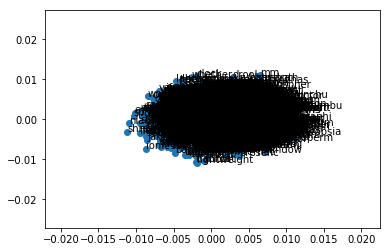

In [23]:
# plot word vectors using PCA
from matplotlib import pyplot
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
result = pca.fit_transform(X)
# create a scatter plot
pyplot.scatter(result[:,0],result[:,1])
words = list(ebd_model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i,0], result[i,1]))
pyplot.show()

In [97]:
# if we want to use google word2vec
#from gensim.models import Word2Vec
#word2vec = KeyedVectors.load_word2vec_format('/home/ramscrux7757/SPARK/AI_SCIENCE/GoogleNews-vectors-negative300.bin', binary=True)

# Modeling part (LSTM w/ Attention)

In [21]:
# Splitting the data
Xqtrain, Xqtest, Xatrain,Xatest,Ytrain,Ytest = train_test_split(Xq,Xa,Y,test_size=0.3,random_state=123)
print(Xqtrain.shape, Xqtest.shape,Xatrain.shape,Xatest.shape,Ytrain.shape,Ytest.shape)

# Y - is a True/False matrix w.r.to 'A'

((7000, 100), (3000, 100), (7000, 100), (3000, 100), (7000, 2), (3000, 2))


In [22]:
# network for questions
qin = Input(shape=(seq_maxlen,), dtype="int32") # seq_maxlen = 100
# vocab_size = 5736; WORD2VEC_EMBED_SIZE = 100

qenc = Embedding(input_dim=vocab_size,
                 output_dim=word2vec_embed_size,
                 input_length=seq_maxlen,
                 weights=[embedding_weights])(qin)

# QA_EMBED_SIZE = 64
qenc = LSTM(qa_embed_size, return_sequences=True)(qenc)
qenc = Dropout(0.3)(qenc)

In [23]:
# network for answers
# output: (None, QA_EMBED_SIZE, seq_maxlen)
ain = Input(shape=(seq_maxlen,), dtype="int32")
aenc = Embedding(input_dim=vocab_size,
                 output_dim= word2vec_embed_size,
                 input_length=seq_maxlen,
                 weights=[embedding_weights])(ain)
aenc = LSTM(qa_embed_size, return_sequences=True)(aenc)
aenc = Dropout(0.3)(aenc)

In [24]:
# attention model (dot product)
attn = merge([qenc, aenc], mode="dot", dot_axes=[1, 1])
attn = Flatten()(attn)
attn = Dense(seq_maxlen * qa_embed_size)(attn)
attn = Reshape((seq_maxlen, qa_embed_size))(attn)

# merging using 'sum'
qenc_attn = merge([qenc, attn], mode="sum")
qenc_attn = Flatten()(qenc_attn)

output = Dense(2, activation="softmax")(qenc_attn)

model = Model(input=[qin, ain], output=[output])

model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 100, 100)      573600      input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 100, 100)      573600      input_2[0][0]                    
___________________________________________________________________________________________

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app
/usr/local/anaconda/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [25]:
# training the data and saving the model
checkpoint = ModelCheckpoint(
    filepath=('/home/ramscrux7757/SPARK/AI_SCIENCE/qa-lstm-attn-best.hdf5'),
    verbose=1, save_best_only=True)

history = model.fit([Xqtrain, Xatrain], [Ytrain], batch_size=batch_size, 
                    nb_epoch=10, validation_split=0.1,callbacks=[checkpoint])

print("Evaluation...")
loss, acc = model.evaluate([Xqtest, Xatest], [Ytest], batch_size=batch_size)
print("Test loss/accuracy final model = %.4f, %.4f" % (loss, acc))
# save the model
#model.save('/home/ramscrux7757/SPARK/AI_SCIENCE/model.h5')

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 6300 samples, validate on 700 samples
Epoch 1/10
6300/6300 [==============================] - 89s - loss: 0.5712 - acc: 0.7432 - val_loss: 0.5797 - val_acc: 0.7343
Epoch 2/10
6300/6300 [==============================] - 84s - loss: 0.5631 - acc: 0.7498 - val_loss: 0.5804 - val_acc: 0.7343
Epoch 3/10
6300/6300 [==============================] - 85s - loss: 0.5589 - acc: 0.7498 - val_loss: 0.6496 - val_acc: 0.6443
Epoch 4/10
6300/6300 [==============================] - 81s - loss: 0.5064 - acc: 0.7659 - val_loss: 0.6726 - val_acc: 0.7214
Epoch 5/10
6300/6300 [==============================] - 89s - loss: 0.4220 - acc: 0.8030 - val_loss: 0.8366 - val_acc: 0.6686
Epoch 6/10
6300/6300 [==============================] - 93s - loss: 0.3622 - acc: 0.8289 - val_loss: 0.9477 - val_acc: 0.6957
Epoch 7/10
6300/6300 [==============================] - 86s - loss: 0.3210 - acc: 0.8484 - val_loss: 1.3140 - val_acc: 0.6400
Epoch 8/10
6300/6300 [==============================] - 86s - loss: 0.2

In [35]:
# Summarizing the Accuracy
#import matplotlib.pyplot as plt
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.xlabel('epoch')
#plt.ylabel('accuracy')
#plt.legend(['train','validation'], loc='upper left')
#plt.show()

In [26]:
# loading the model and evaluating the test data
from keras.models import load_model
svd_model = load_model('/home/ramscrux7757/SPARK/AI_SCIENCE/qa-lstm-attn-best.hdf5')
# svd_model = load_model('/home/ramscrux7757/SPARK/AI_SCIENCE/model.h5')
#svd_model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])
loss, acc = svd_model.evaluate([Xqtest, Xatest], [Ytest], batch_size=batch_size)
print("Test loss/accuracy best model = {}, {}".format(loss,acc))

/usr/local/anaconda/lib/python2.7/site-packages/keras/engine/topology.py:1252: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


3000/3000 [==============================] - 8s     
Test loss/accuracy best model = 0.558684201399, 0.754000000318


In [40]:
svd_model.predict([Xqtest, Xatest], batch_size=batch_size)
# these predictions are compared against the Ytest

array([[ 0.25655362,  0.74344635],
       [ 0.25579777,  0.7442022 ],
       [ 0.25800636,  0.74199367],
       ..., 
       [ 0.25846583,  0.74153417],
       [ 0.25667426,  0.74332577],
       [ 0.25576738,  0.74423265]], dtype=float32)

In [41]:
print(Ytest) # vectorized form of True/False (correct_ans_idx = ord(correct_ans) - ord('A'))

[[1 0]
 [1 0]
 [0 1]
 ..., 
 [0 1]
 [0 1]
 [0 1]]


In [45]:
# saving the model as separate files
from numpy import array
from keras.models import model_from_json

# convert the architecture to 'json' or 'yaml' file
architecture = model.to_json()
with open('/home/ramscrux7757/SPARK/AI_SCIENCE/architecture.json','wt') as json_file:
    json_file.write(architecture)

# saving the weights as *.hdf5 file
#model.save_weights('weights.h5')
#model.save_weights('/home/ramscrux7757/SPARK/AI_SCIENCE/weights.h5')

In [ ]:
# Loading the model
from keras.models import model_from_json
json_file = open('/home/ramscrux7757/SPARK/AI_SCIENCE/architecture.json','rt')
architecture = json_file.read()
json_file.close()
# create model from architecture
model = model_from_json(architecture)

# loading weights
model = model.load_weights('/home/ramscrux7757/SPARK/AI_SCIENCE/weights.h5')

# making predictions
yhat = model.predict(X, verbose=0)
yhat = model.predict_classes(X)
yhat = model.predict_proba(X)
print(yhat)

# On the test set

In [ ]:
# The next step takes the saved model (final one) and runs each question 
# in the test set and its four choices as a single batch, and predicts 
# the correct answer as the one which has the highest score. 

In [91]:
# Vectorizing the test set
def vectorize_qapairs(qapairs, word2idx, seq_maxlen):
    Xtq, Xta = [], []
    for qapair in qapairs:
        Xtq.append([word2idx[qword] for qword in qapair[0]])
        Xta.append([word2idx[aword] for aword in qapair[1]])
        #Y.append(np.array([1, 0]) if qapair[2] else np.array([0, 1]))
    return (pad_sequences(Xtq, maxlen=seq_maxlen), 
            pad_sequences(Xta, maxlen=seq_maxlen))
            #np.array(Y))

# index encoded qapairs vectors
Xtq, Xta = vectorize_qapairs(tqapairs, word2idx, seq_maxlen)
#print(Xtq)
#print(Xta)
#print(Y)

In [28]:
print(Xtq.shape)
print(Xta.shape)

(32528, 100)
(32528, 100)


In [ ]:
#Xtq[0/1/2/3] - question no: 1
#Xta[0] - answer 'A'
#Xta[1] - answer 'B'
#Xta[2] - answer 'C'
#Xta[3] - answer 'D'
# in the answer's vectors, if a single word is the answer, we will have one non-zero element in the vector at the end

In [52]:
Xtq[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7,
       822, 376,  70,  20, 101, 334,  37,  17,  16], dtype=int32)

In [53]:
Xta[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  334,   12,
       1145], dtype=int32)

In [66]:
Xtq[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7,
       822, 376,  70,  20, 101, 334,  37,  17,  16], dtype=int32)

In [58]:
Xta[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       1749], dtype=int32)

# The following prediction is for demonstration purpuses only
# The accuracy is not better than random

In [90]:
# a question and the corresponding answer set is supplied 
#for i in range(Xtq.shape[0]):

for i in range(10):
    x1 = Xtq[i]
    xq1 = np.array([x1]) # transposing the vector
    probs_list = []
    for j in range(i, i+4): 
        x2 = Xta[j]
        xa1 = np.array([x2])

        Y = svd_model.predict([xq1,xa1])

# consider the difference b/w the positive and negative o/p as the score followed by normalization
# gives the probabilities of all 
        probs = np.exp(1.0 - (Y[:, 1] - Y[:, 0]))
        probs_list.append(probs)

# the following should covert the numeric into the correct character
    correct_answer = chr(ord('A') + np.argmax(probs_list))
    
#    print(Y.shape)
#        print(Y)
#print('---------------')
#print(Y[:,0])
#print('---------------')
#print(Y[:,1])
#print('----------------')
#print(len(probs))
#        print(probs)
#print('----------------')
#    print(np.argmax(probs))
#print('----------------')
    print('Question {}:'.format(i+1))
    print('probability of Answers: {}'.format(probs_list))
    print('correct_answer_predicted: {}'.format(correct_answer))
    print

Question 1:
probability of Answers: [array([ 1.67015743], dtype=float32), array([ 1.66981757], dtype=float32), array([ 1.67062938], dtype=float32), array([ 1.67023623], dtype=float32)]
correct_answer_predicted: C

Question 2:
probability of Answers: [array([ 1.66981757], dtype=float32), array([ 1.67062938], dtype=float32), array([ 1.67023623], dtype=float32), array([ 1.66986775], dtype=float32)]
correct_answer_predicted: B

Question 3:
probability of Answers: [array([ 1.67062938], dtype=float32), array([ 1.67023623], dtype=float32), array([ 1.66986775], dtype=float32), array([ 1.66985476], dtype=float32)]
correct_answer_predicted: A

Question 4:
probability of Answers: [array([ 1.67023623], dtype=float32), array([ 1.66986775], dtype=float32), array([ 1.66985476], dtype=float32), array([ 1.66988158], dtype=float32)]
correct_answer_predicted: A

Question 5:
probability of Answers: [array([ 1.66956103], dtype=float32), array([ 1.66944647], dtype=float32), array([ 1.66940343], dtype=float3